Wanted to build on the [individual-level regression](https://github.com/antiraids/london-immigration-raids-map/blob/master/Outputs/RaidsByEthnicity.png) already done, by doing a multiple linear regression.

In [167]:
import arviz as az
import bambi as bmb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
from scipy.special import boxcox, inv_boxcox
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [44]:
from IPython.display import Image, display

In [38]:
# %cd Documents\\Python Scripts\\london-immigration-raids-map

In [39]:
ethn = pd.read_csv('AmendedData\\PostcodeEthnicityRates_keylines.csv', index_col=['postdist'])
raid = pd.read_csv('AmendedData\\PopnRaidsRate.csv', index_col=['Postcode'])
ethn.head()

,total,Other White,Indian,Pakistani,Bangladeshi,Chinese,Other Asian,African,Caribbean,Other Black,Arab
postdist,,,,,,,,,,,
AL1,36180,2645,658,574,1406,397,701,413,370,112,164
AL10,35900,2957,2015,479,288,1347,1013,2567,430,168,370
AL2,23604,1115,556,110,413,212,519,236,170,33,91
AL3,28462,1366,370,143,497,139,231,153,183,62,91
AL4,27268,1167,320,192,207,179,243,202,130,52,74


In [40]:
# Make counts into rates
ethns = ethn.iloc[:, 1:].columns
for col in ethns:
    ethn[col] = ethn[col] / ethn['total']

In [42]:
# Join raid and ethnicity data
raideth = raid.join(ethn)
na_check = raideth[raideth.isna().any(axis=1)]
assert (na_check['Residents'] < 5000).all()  # check all NAs are weird postdist
raideth.dropna(inplace=True)
raideth.head()

,Residents,Count,Rate,total,Other White,Indian,Pakistani,Bangladeshi,Chinese,Other Asian,African,Caribbean,Other Black,Arab
Postcode,,,,,,,,,,,,,,
E1,70389.0,787.0,11.180724,70389.0,0.118598,0.021026,0.014349,0.425919,0.020912,0.023555,0.031369,0.013710,0.012573,0.012431
E10,43120.0,650.0,15.074212,43120.0,0.177922,0.047426,0.155844,0.026739,0.014193,0.052690,0.090631,0.093854,0.034949,0.016558
E11,54689.0,307.0,5.613560,54689.0,0.151456,0.062151,0.073616,0.027428,0.012525,0.034358,0.067143,0.063815,0.021375,0.015286
E12,42606.0,667.0,15.655072,42606.0,0.061635,0.207201,0.140168,0.166338,0.002676,0.067807,0.088485,0.044900,0.018941,0.009459
E13,47169.0,790.0,16.748288,47169.0,0.112320,0.102970,0.088130,0.139074,0.008523,0.067587,0.141534,0.052238,0.027624,0.009561


# First step: naive regression

Run a basic linear regression on the "Rate" variable, using the ethnicity rates as independent variables.

In [52]:
scalex = MinMaxScaler()
X_scaled = scalex.fit_transform(raideth[ethns])

# Scale x, leave y
y = raideth['Rate']
model1 = LinearRegression()
model1.fit(X_scaled, y)
print(f'Score: {model1.score(X_scaled, y):.3f}\nIntercept: {model1.intercept_:.3f}\n')
print('Regression coefficients:')
for e, c in zip(ethns, model1.coef_):
    print(f'- {e}: {c:.2f}')

Score: 0.219
Intercept: -44.075

Regression coefficients:
- Other White: 160.47
- Indian: 46.85
- Pakistani: 16.29
- Bangladeshi: 16.33
- Chinese: 1.15
- Other Asian: -19.46
- African: 23.08
- Caribbean: -41.60
- Other Black: 48.97
- Arab: -72.69


This gives a very high weight to "Other White" as a category -- which in some ways makes sense, as that matches deportation data:

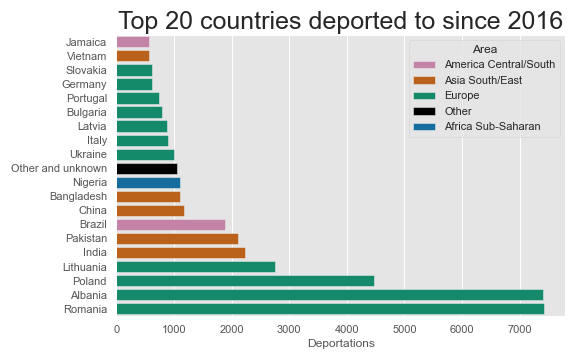

In [53]:
display(Image(filename='Outputs\\Deportations_by_place_2016.png'))

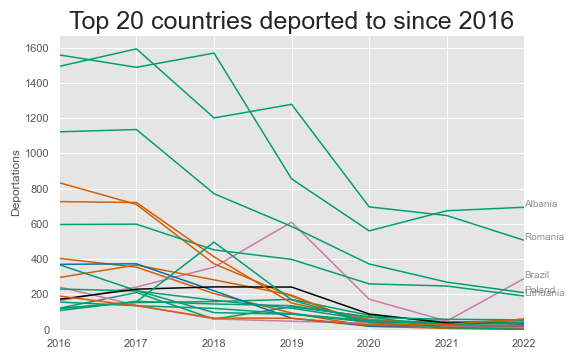

In [54]:
display(Image(filename='Outputs\\Deportations_by_place_2016_by_year.png'))

However, this is probably too naive: the values aren't distributed as you'd need to be able to run a naive regression.

Also, it's hard to interpret the coefficients here => try a Bayesian multiple regression, so we can get an idea of how the uncertainty is constrained.

# Bayesian multiple regression

Tried out [Bambi](https://bambinos.github.io/bambi/index.html), as a Bayesian version of regression / a Python version of Bayesian regression, built in Stan.

In [58]:
df_scaled = pd.DataFrame(X_scaled)  # Use the min-max scaled data
df_scaled.columns = [e.replace(" ", "") for e in ethns]  # Remove spaces from column names
df_scaled['raids_per_k'] = raideth['Rate'].values
df_scaled.head(1)

,OtherWhite,Indian,Pakistani,Bangladeshi,Chinese,OtherAsian,African,Caribbean,OtherBlack,Arab,raids_per_k
0,0.167918,0.078296,0.092072,1.0,0.127623,0.117999,0.089519,0.079626,0.184869,0.105174,11.180724


In [59]:
bmodel1 = bmb.Model("raids_per_k ~ OtherWhite + Indian + Pakistani + Bangladeshi\
+ Chinese + OtherAsian + African + Caribbean + OtherBlack + Arab", df_scaled)
fitted1 = bmodel1.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, OtherWhite, Indian, Pakistani, Bangladeshi, Chinese, OtherAsian, African, Caribbean, OtherBlack, Arab, raids_per_k_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 115 seconds.


In [72]:
# Checks, suggested by https://www.jstatsoft.org/article/download/v103i15/4345
summary1 = az.summary(fitted1)
assert max(summary1['r_hat']) < 1.01
assert summary1[['ess_bulk', 'ess_tail']].min().min() > 2*50
summary1.to_csv('AmendedData\\bambi_summary_naive.csv')
summary1[['mean', 'sd']]

,mean,sd
Intercept,-43.983,15.623
OtherWhite,160.639,28.216
Indian,46.652,35.331
Pakistani,15.676,31.209
Bangladeshi,17.252,30.474
Chinese,1.656,24.765
OtherAsian,-20.074,25.328
African,25.104,40.138
Caribbean,-39.573,49.185
OtherBlack,45.916,51.959


To interpret this:

- the residuals had mean 45 (SD 2.8)
- the intercept was -44 (SD 15) -- a bit meaningless, as there are no areas that are 100% "white British"
- "OtherWhite" had the strongest contribution (160 SD 29), with all others basically around the levels of noise

i.e. if there were two areas, ceteris paribus, then under this model you'd expect an additional 10% of 'OtherWhite' residents to drive 16 more raids (+/- 3) per 1000 people.

C:\Users\setat\Anaconda3\lib\site-packages\arviz\plots\backends\matplotlib\pairplot.py:236: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  UserWarning,


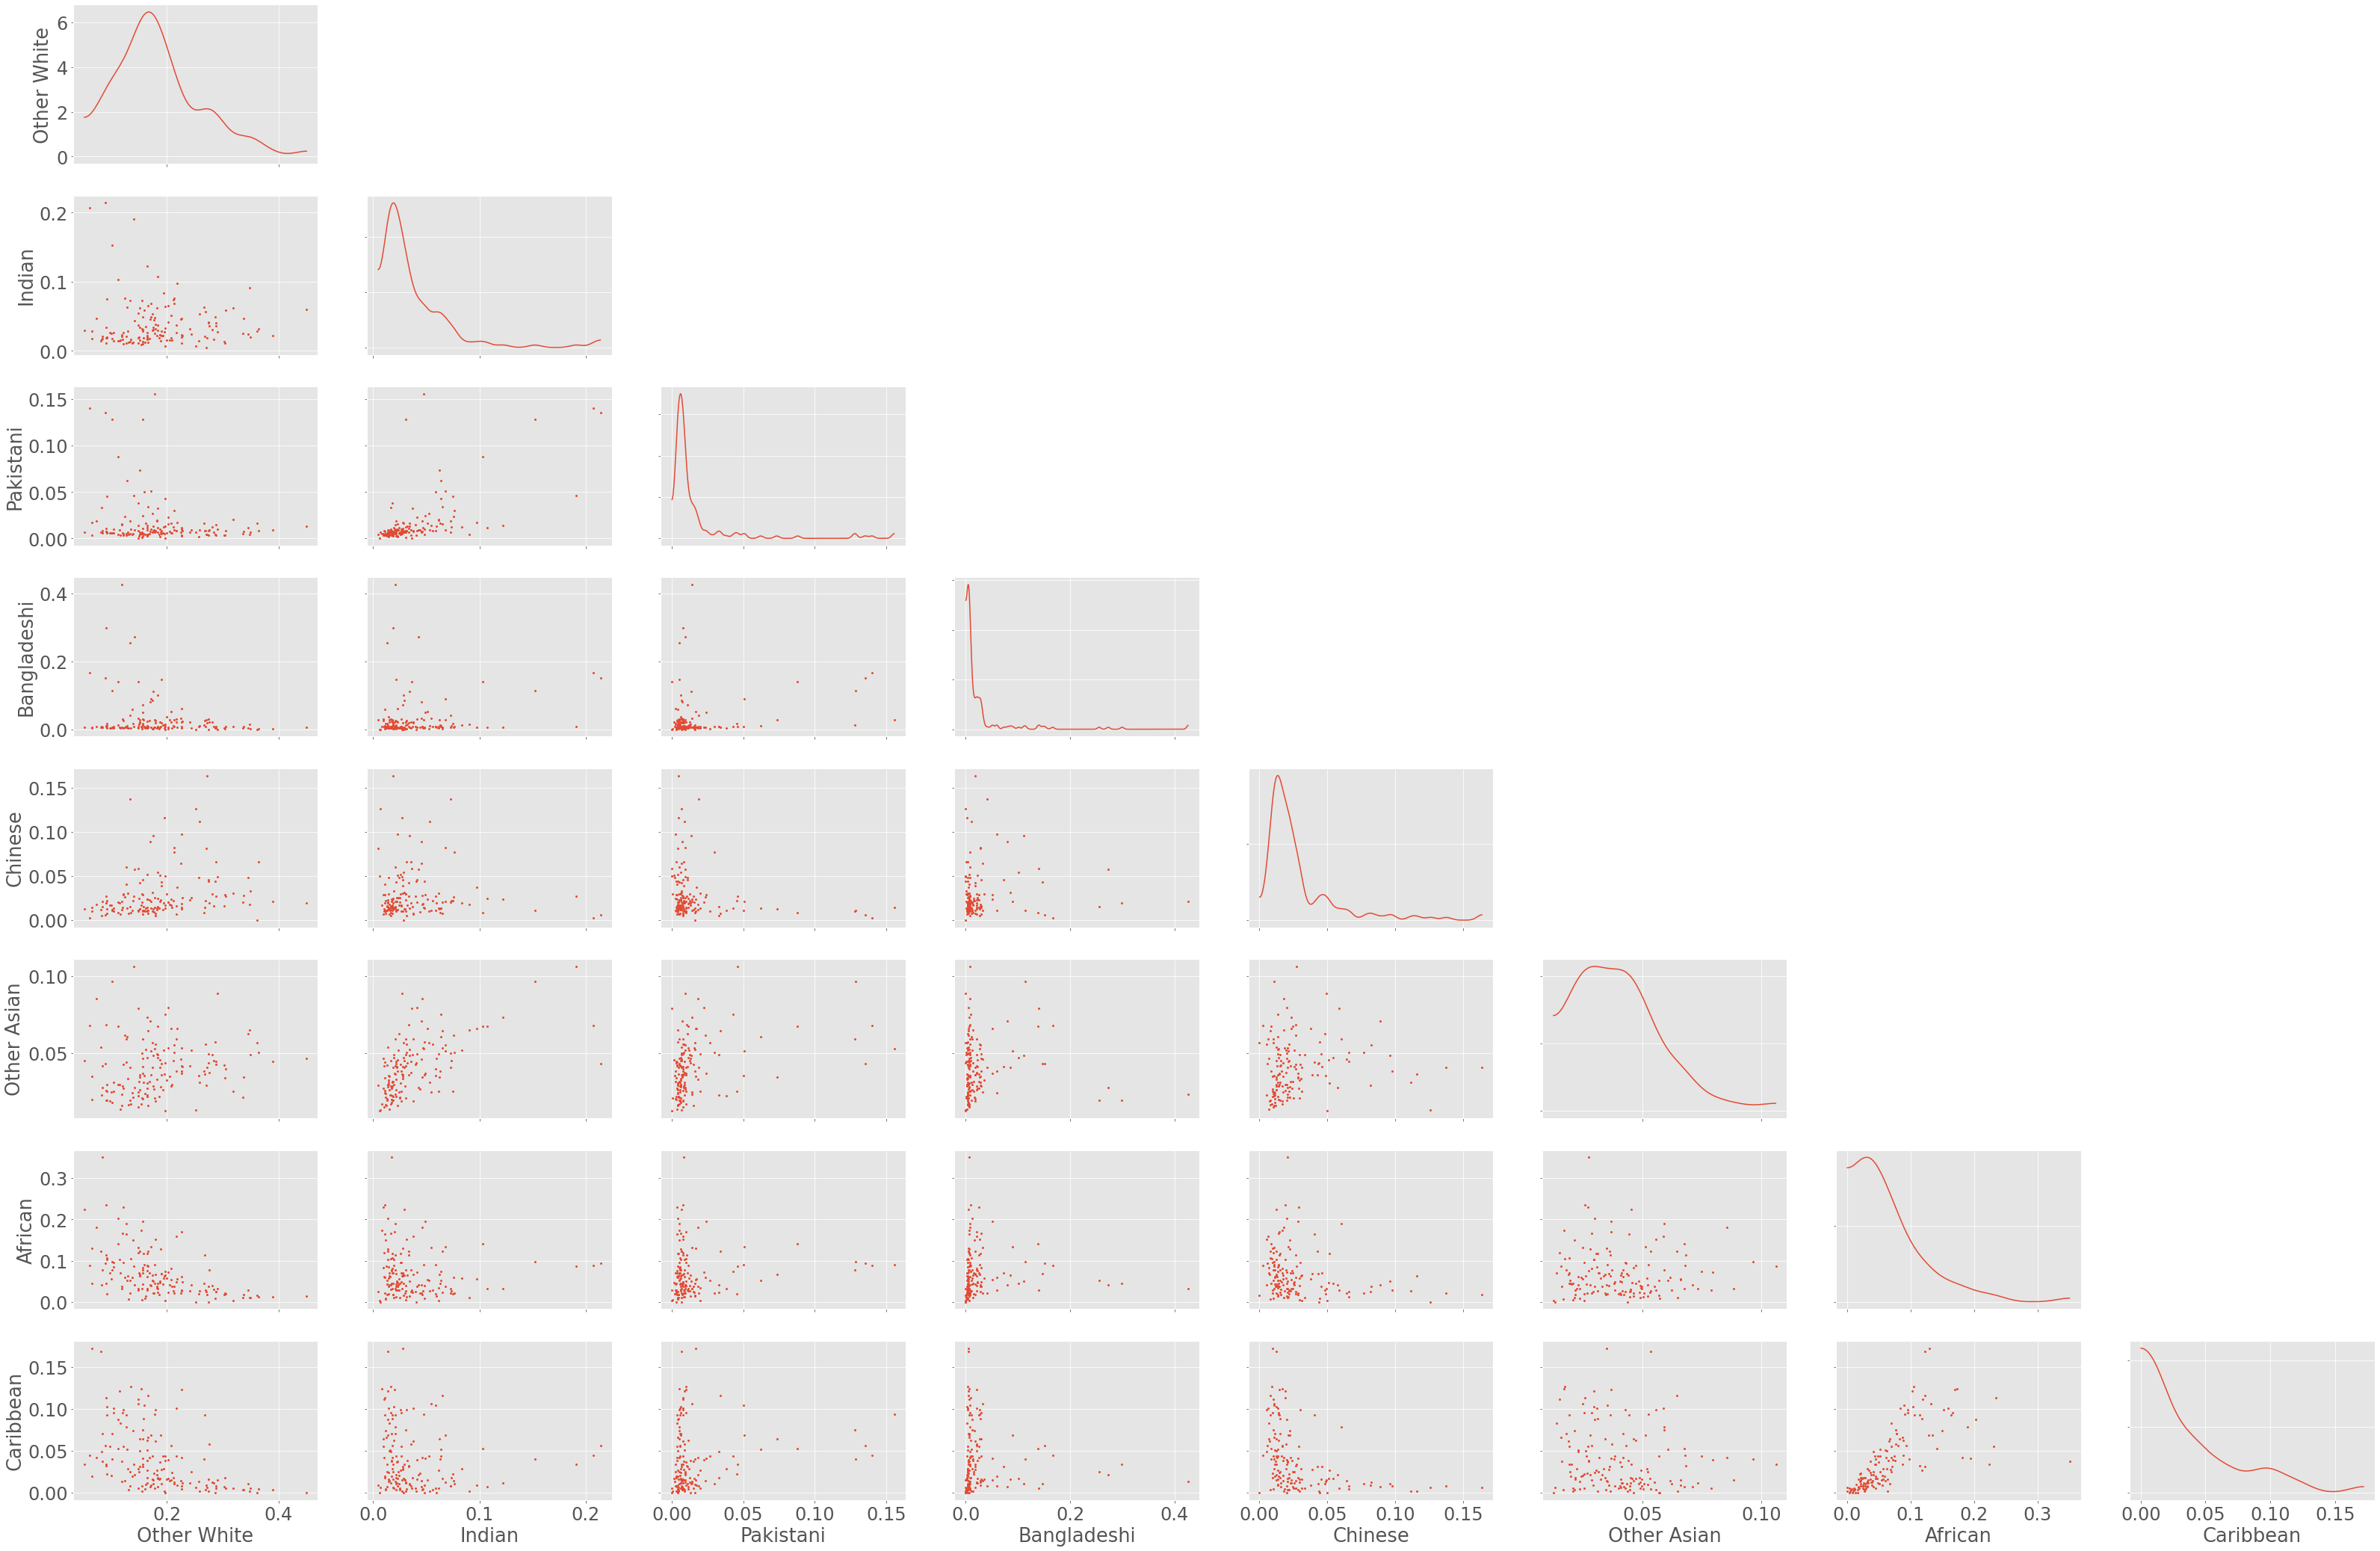

In [73]:
az.plot_trace(fitted1)
az.plot_pair(raideth[ethns].to_dict("list"),
             marginals=True,
             textsize=24);

# Transforming the data

Let's try transforming the data, so that its distribution is a bit more reasonable for linear regression.

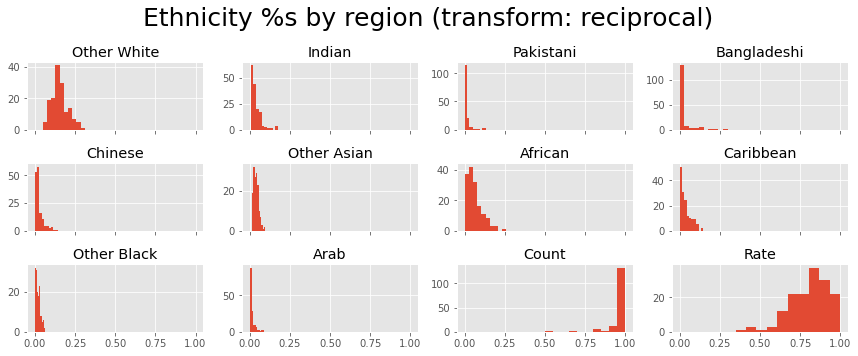

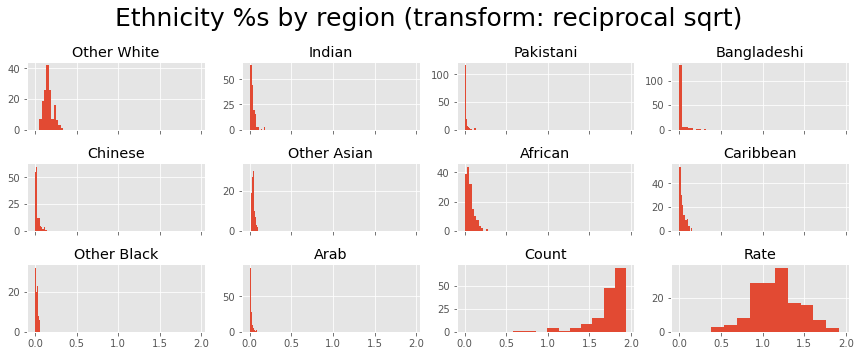

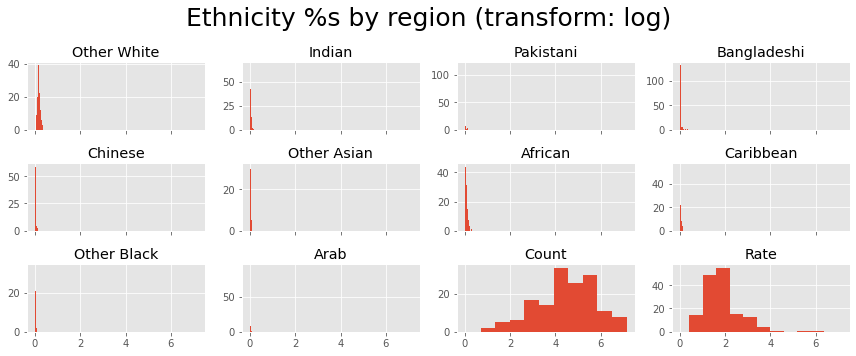

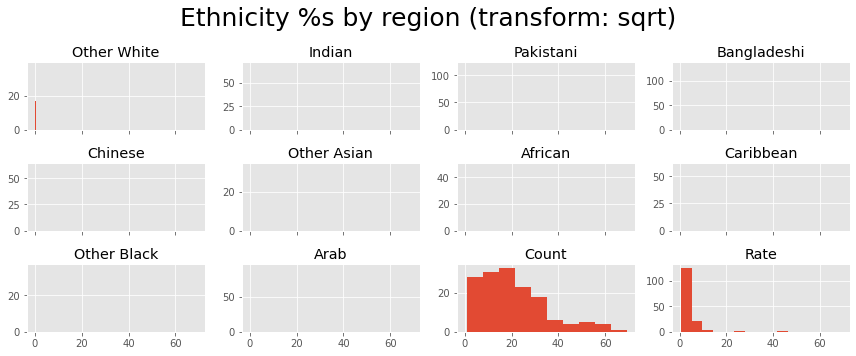

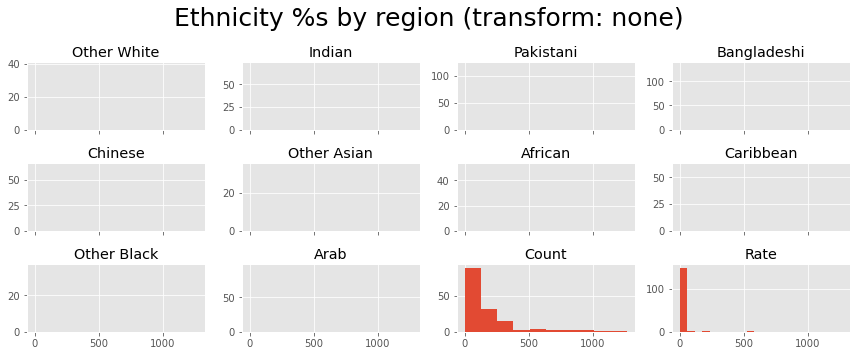

In [81]:
transform_cols = list(ethns) + ['Count', 'Rate']
transforms = {'reciprocal': -1,
              'reciprocal sqrt': -0.5,
              'log': 0,
              'sqrt': 0.5,
              'none': 1}
for k, v in transforms.items():
    figs, axs = plt.subplots(3, 4, figsize=(12, 5), sharex=True)
    for e, ax in zip(transform_cols, axs.flatten()):
        ax.hist(boxcox(raideth[e] + 1, v))
        ax.set_title(e)
    plt.suptitle(f'Ethnicity %s by region (transform: {k})', fontsize=25)
    plt.tight_layout()
    plt.savefig(f'Outputs\\ethn_spread_{k}.png')
    plt.show()

The transformations are clearly adapting the data => let boxcox optimise itself, save the variable in case want to reverse.

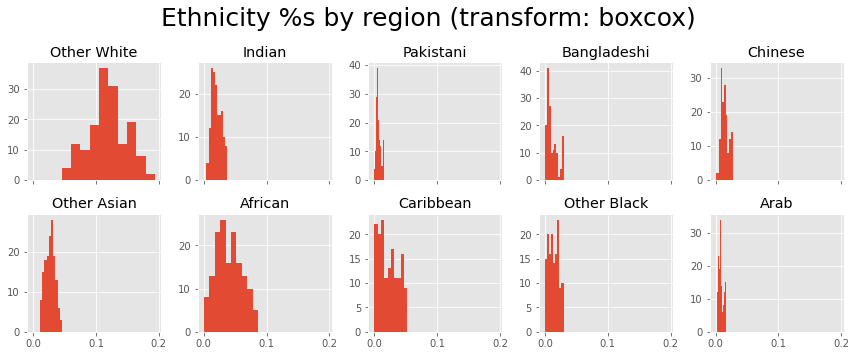

In [82]:
boxcoxs = dict()
figs, axs = plt.subplots(2, 5, figsize=(12, 5), sharex=True)
for e, ax in zip(ethns, axs.flatten()):
    eth_trans = boxcox(raideth[e] + 1)
    ax.hist(eth_trans[0])
    ax.set_title(e)
    boxcoxs[e] = {'data': eth_trans[0], 'lambda': eth_trans[1]}
plt.suptitle('Ethnicity %s by region (transform: boxcox)', fontsize=25)
plt.tight_layout()
plt.savefig('Outputs\\ethn_spread_boxcox.png')

Looks a lot more normally distributed! Let's check what that does on a frequentist regression.

In [83]:
model2 = LinearRegression()
scalex = MinMaxScaler()
X_scaled = scalex.fit_transform(pd.DataFrame([boxcoxs[e]['data']
                                              for e in ethns]).T)
model2.fit(X_scaled, y)

print(f'Score: {model2.score(X_scaled, y):.3f}\nIntercept: {model2.intercept_:.3f}\n')
print('Regression coefficients:')
for e, c in zip(ethns, model2.coef_):
    print(f'- {e}: {c:.2f}')

Score: 0.206
Intercept: -28.774

Regression coefficients:
- Other White: 135.68
- Indian: -3.98
- Pakistani: 46.64
- Bangladeshi: -0.39
- Chinese: -23.65
- Other Asian: 4.85
- African: 25.09
- Caribbean: -124.44
- Other Black: 97.10
- Arab: -80.51


Looks plausible => train Bambi.

In [85]:
df_scaled2 = pd.DataFrame(X_scaled)
df_scaled2.columns = [e.replace(" ", "") for e in ethns]
df_scaled2['raids_per_k'] = raideth['Rate'].values
df_scaled2.head(1)

,OtherWhite,Indian,Pakistani,Bangladeshi,Chinese,OtherAsian,African,Caribbean,OtherBlack,Arab,raids_per_k
0,0.301734,0.35055,0.592646,1.0,0.536162,0.22488,0.301018,0.230221,0.342672,0.453003,11.180724


In [86]:
bmodel2 = bmb.Model("raids_per_k ~ OtherWhite + Indian + Pakistani + Bangladeshi\
+ Chinese + OtherAsian + African + Caribbean + OtherBlack + Arab", df_scaled2)
fitted2 = bmodel2.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, OtherWhite, Indian, Pakistani, Bangladeshi, Chinese, OtherAsian, African, Caribbean, OtherBlack, Arab, raids_per_k_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 106 seconds.


In [88]:
# Checks, suggested by https://www.jstatsoft.org/article/download/v103i15/4345
summary2 = az.summary(fitted2)
assert max(summary2['r_hat']) < 1.01
assert summary2[['ess_bulk', 'ess_tail']].min().min() > 2*50
summary2.to_csv('AmendedData\\bambi_summary_boxcox.csv')
summary2[['mean', 'sd']]

,mean,sd
Intercept,-28.073,24.452
OtherWhite,134.022,30.372
Indian,-3.433,27.620
Pakistani,45.800,24.699
Bangladeshi,-0.412,14.434
Chinese,-23.169,21.928
OtherAsian,3.670,26.537
African,24.952,36.828
Caribbean,-121.772,40.539
OtherBlack,94.056,42.750


To interpret this:

- the residuals had mean 46 (SD 2.6)
- the intercept was -28 (SD 24) -- a bit meaningless, as there are no areas that are 100% "white British"
- "OtherWhite" had the strongest contribution (134 SD 30), with all others basically around the levels of noise

Transforming this data should hopefully constrain the noise of the estimated parameters. Let's check.

In [90]:
# Check out the sd comparison
summary1[['sd']].join(summary2['sd'], rsuffix='2')

,sd,sd2
Intercept,15.623,24.452
OtherWhite,28.216,30.372
Indian,35.331,27.620
Pakistani,31.209,24.699
Bangladeshi,30.474,14.434
Chinese,24.765,21.928
OtherAsian,25.328,26.537
African,40.138,36.828
Caribbean,49.185,40.539
OtherBlack,51.959,42.750


As expected, the SDs are (mostly) constrained! Phew.

In [96]:
# az.plot_ppc(fitted2)

Plot the estimates, along with the 95% error interval.

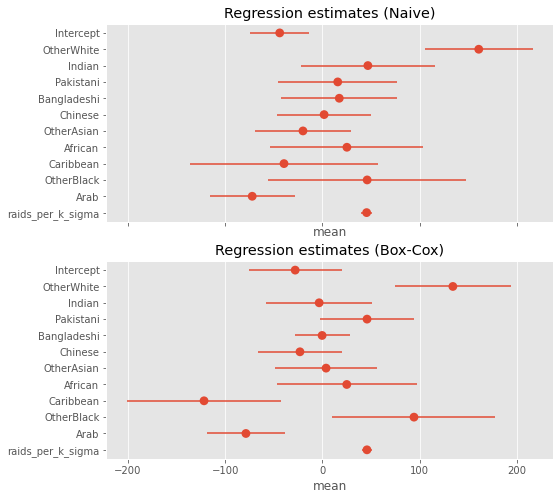

In [99]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
for summ, t, ax in zip([summary1, summary2], ['Naive', 'Box-Cox'], axs):
    sns.pointplot(x='mean', y=summ.index, data=summ,
                  dodge=True, join=False, ci=None, ax=ax)
    # Get points, to use for error bars
    x_coords = []
    y_coords = []
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            x_coords.append(x)
            y_coords.append(y)
    ax.errorbar(x_coords, y_coords, xerr=(1.96*summ['sd']).values, fmt=' ')
    ax.set_title(f'Regression estimates ({t})')
plt.savefig('Outputs\\ethn_regr_coefs.png')

# Side-note: some issues

One thing to note is that most raids_per_k values are <5/1000.

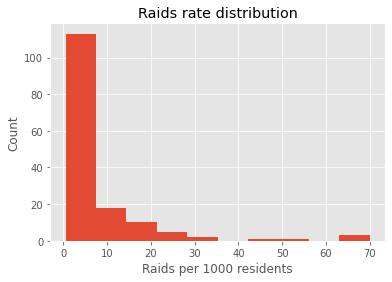

In [105]:
df_scaled['raids_per_k'].describe()
df_scaled['raids_per_k'].sort_values().clip(0, 70).hist()
plt.xlabel("Raids per 1000 residents")
plt.ylabel("Count")
plt.title("Raids rate distribution");

Also, many of the raids_per_k outliers are small places:

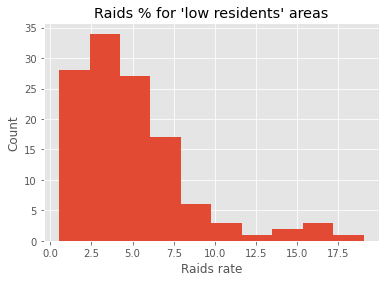

In [108]:
raideth[raideth['Residents'] < raideth['Residents'].quantile(0.2)]
raideth[raideth['Residents'] > raideth['Residents'].quantile(0.2)]['Rate'].hist()
plt.xlabel("Raids rate")
plt.ylabel("Count")
plt.title("Raids % for 'low residents' areas");

=> Let's try to reduce more noise by removing some of the 'low residents' areas.

# 'Final' model

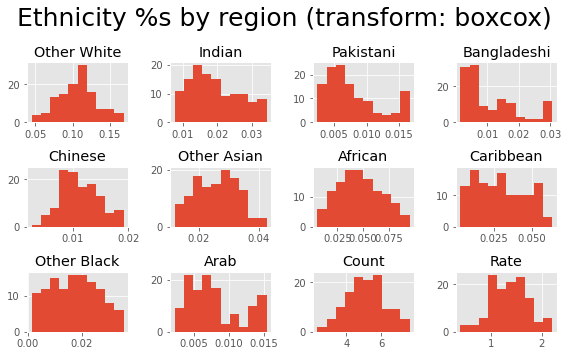

In [110]:
raideth_trim = raideth[raideth['Residents'] > raideth['Residents'].quantile(0.2)].copy()
to_boxcox = list(ethns) + ['Count', 'Rate']
boxcox_trim = dict()
figs, axs = plt.subplots(3, 4, figsize=(8, 5))
for e, ax in zip(to_boxcox, axs.flatten()):
    eth_trans = boxcox(raideth_trim[e] + 1)
    ax.hist(eth_trans[0])
    ax.set_title(e)
    boxcox_trim[e] = {'data': eth_trans[0], 'lambda': eth_trans[1]}
plt.suptitle('Ethnicity %s by region (transform: boxcox)', fontsize=25)
plt.tight_layout()
plt.savefig('Outputs\\ethn_trim_spread_boxcox_inc_rate.png')

Let's do a frequentist check, before running the Bayesian model.

In [142]:
model3 = LinearRegression()
scalex = MinMaxScaler()
boxcox_trimmed = pd.DataFrame([boxcox_trim[e]['data'] for e in ethns]).T
X_scaled = scalex.fit_transform(boxcox_trimmed)
y_scaled = boxcox_trim['Rate']['data']
model3.fit(X_scaled, y_scaled)

LinearRegression()

In [143]:
# boxcox_trim['Rate']['data']

In [144]:
print(f'Score: {model3.score(X_scaled, y_scaled):.3f}\nIntercept: {model3.intercept_:.3f}\n')

print('Regression coefficients:')
for e, c in zip(ethns, model3.coef_):
    print(f'- {e}: {c:.2f}')

Score: 0.623
Intercept: 0.304

Regression coefficients:
- Other White: 0.30
- Indian: -0.18
- Pakistani: 0.58
- Bangladeshi: 0.30
- Chinese: 0.41
- Other Asian: 0.23
- African: 0.90
- Caribbean: 0.25
- Other Black: -0.30
- Arab: -0.09


Different! Let's train the Bayesian model.

In [121]:
df_scaletrim = pd.DataFrame(X_scaled)
df_scaletrim.columns = [e.replace(" ", "") for e in ethns]
df_scaletrim['raids_per_k'] = boxcox_trim['Rate']['data']
df_scaletrim.head(1)

,OtherWhite,Indian,Pakistani,Bangladeshi,Chinese,OtherAsian,African,Caribbean,OtherBlack,Arab,raids_per_k
0,0.343559,0.301521,0.502732,1.0,0.612463,0.214453,0.232515,0.151465,0.282651,0.47711,1.934599


In [122]:
bmodel3 = bmb.Model("raids_per_k ~ OtherWhite + Indian + Pakistani + Bangladeshi\
+ Chinese + OtherAsian + African + Caribbean + OtherBlack + Arab", df_scaletrim)
fitted3 = bmodel3.fit()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, OtherWhite, Indian, Pakistani, Bangladeshi, Chinese, OtherAsian, African, Caribbean, OtherBlack, Arab, raids_per_k_sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 99 seconds.


In [123]:
# Checks, suggested by https://www.jstatsoft.org/article/download/v103i15/4345
summary3 = az.summary(fitted3)
assert max(summary3['r_hat']) < 1.01
assert summary3[['ess_bulk', 'ess_tail']].min().min() > 2*50
summary3.to_csv('AmendedData\\bambi_summary_boxcox_trim.csv')
summary3[['mean', 'sd']]

,mean,sd
Intercept,0.305,0.116
OtherWhite,0.303,0.161
Indian,-0.177,0.147
Pakistani,0.583,0.131
Bangladeshi,0.304,0.082
Chinese,0.410,0.131
OtherAsian,0.238,0.156
African,0.896,0.232
Caribbean,0.242,0.282
OtherBlack,-0.288,0.353


N.B. as hoped, the point estimates broadly match the frequentist model, but we now have estimates of the uncertainty too.

### What these mean

Most of the coefficients are within the noise of the residuals. Only a few stand out from the noise: OtherWhite, Pakistani, Bangladeshi, Chinese, African, OtherBlack.

When taking the SDs of the coefficients into account too, a few are too noisy to be interpretable (OtherBlack, OtherWhite) -- potentially because they are aggregate sets of data.

That leaves us with a few factors to explore:

- Pakistani
- Bangladeshi
- Chinese
- African

Let's explore those coefficients visually, and how well-constrained they are:

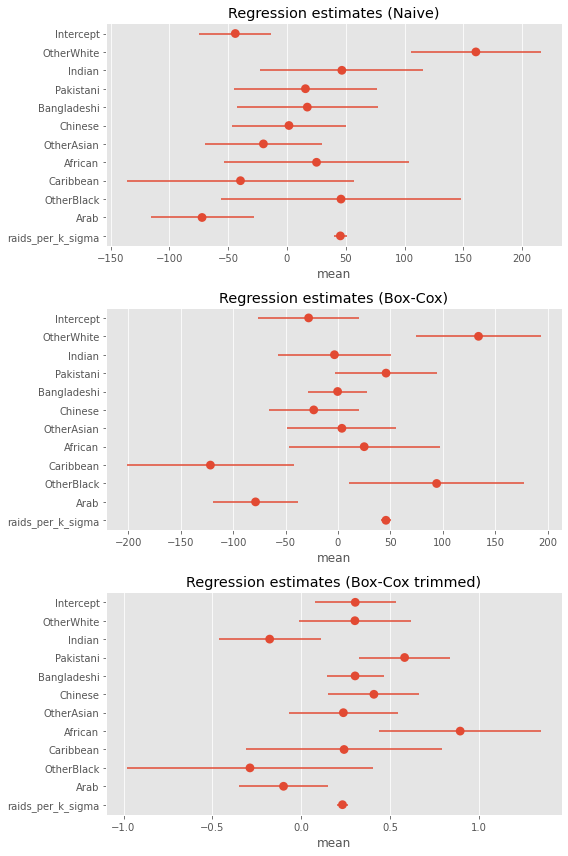

In [132]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
for summ, t, ax in zip([summary1, summary2, summary3],
                       ['Naive', 'Box-Cox', 'Box-Cox trimmed'],
                       axs):
    sns.pointplot(x='mean', y=summ.index, data=summ,
                  dodge=True, join=False, ci=None, ax=ax)
    # Get points, to use for error bars
    x_coords = []
    y_coords = []
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            x_coords.append(x)
            y_coords.append(y)
    ax.errorbar(x_coords, y_coords, xerr=(1.96*summ['sd']).values, fmt=' ')
    ax.set_title(f'Regression estimates ({t})')
plt.tight_layout()
plt.savefig('Outputs\\ethn_regr_coefs_inc_trim.png')

Though these are on the transformed scale (boxcox + min-max) => need to inverse both those transformations.

### Inverse transform data, to interpret coefficients

First, undo the min-max scaler.

In [240]:
mean_unminmax = scalex.inverse_transform(summary3.loc['OtherWhite':'Arab', 'mean'].values.reshape(1, -1))
sd_unminmax = scalex.inverse_transform(summary3.loc['OtherWhite':'Arab', 'sd'].values.reshape(1, -1))

In [225]:
s3_transformed = summary3.loc[:, ['mean', 'sd']].copy()
s3_transformed.columns = ['mean_model', 'sd_model']
s3_transformed['mean_unminmax'] = mean_unminmax[0]
s3_transformed['sd_unminmax'] = sd_unminmax[0]
s3_transformed

,mean_model,sd_model,mean_unminmax,sd_unminmax
OtherWhite,0.303,0.161,0.082363,0.064809
Indian,-0.177,0.147,0.002831,0.011485
Pakistani,0.583,0.131,0.010709,0.004293
Bangladeshi,0.304,0.082,0.010403,0.003915
Chinese,0.410,0.131,0.009331,0.004680
OtherAsian,0.238,0.156,0.019220,0.016713
African,0.896,0.232,0.085639,0.026519
Caribbean,0.242,0.282,0.017837,0.020244
OtherBlack,-0.288,0.353,-0.008461,0.013366
Arab,-0.099,0.129,0.000915,0.003917


In [226]:
# Check that the orders match, else this will make no sense!
assert set([e.replace(" ", "") for e in ethns]) == set(summary3.loc['OtherWhite':'Arab', :].index)

Then, [undo the Box-Cox transformation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.inv_boxcox.html) (this is what the lambdas were stored for earlier).

In [227]:
for e, m, sd in zip(ethns, mean_unminmax[0], sd_unminmax[0]):
    e_nospace = e.replace(" ", "")
    l = boxcox_trim[e]['lambda']
    m_orig = inv_boxcox(m, l) - 1  # added 1 in original transform
    sd_orig = inv_boxcox(sd, l) - 1
    s3_transformed.loc[e_nospace, ['mean', 'sd']] = (m_orig, sd_orig)
    # print(m_orig, sd_orig)
s3_transformed

,mean_model,sd_model,mean_unminmax,sd_unminmax,mean,sd
OtherWhite,0.303,0.161,0.082363,0.064809,0.109379,0.080152
Indian,-0.177,0.147,0.002831,0.011485,0.002959,0.014074
Pakistani,0.583,0.131,0.010709,0.004293,0.017322,0.004979
Bangladeshi,0.304,0.082,0.010403,0.003915,0.012780,0.004196
Chinese,0.410,0.131,0.009331,0.004680,0.012821,0.005372
OtherAsian,0.238,0.156,0.019220,0.016713,0.024760,0.020690
African,0.896,0.232,0.085639,0.026519,0.215053,0.031304
Caribbean,0.242,0.282,0.017837,0.020244,0.020753,0.024116
OtherBlack,-0.288,0.353,-0.008461,0.013366,-0.007750,0.015853
Arab,-0.099,0.129,0.000915,0.003917,0.000944,0.004529


Visualise against other coefficient ranges:

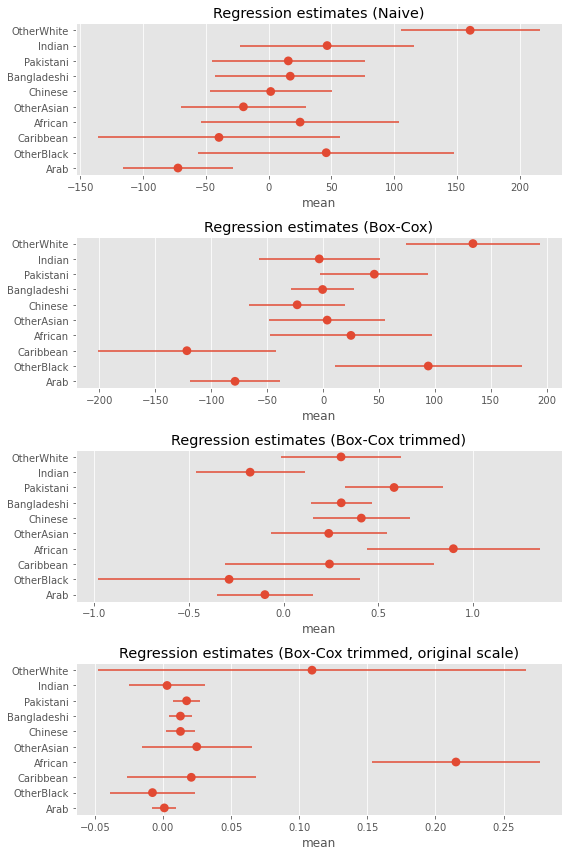

In [237]:
fig, axs = plt.subplots(4, 1, figsize=(8, 12))
for summ, t, ax in zip([summary1, summary2, summary3, s3_transformed],
                       ['Naive', 'Box-Cox', 'Box-Cox trimmed', 'Box-Cox trimmed, original scale'],
                       axs):
    rel_summ = summ.loc['OtherWhite':'Arab', :]
    sns.pointplot(x='mean', y=rel_summ.index, data=rel_summ,
                  dodge=True, join=False, ci=None, ax=ax)
    # Get points, to use for error bars
    x_coords = []
    y_coords = []
    for point_pair in ax.collections:
        for x, y in point_pair.get_offsets():
            x_coords.append(x)
            y_coords.append(y)
    ax.errorbar(x_coords, y_coords, xerr=(1.96*rel_summ['sd']).values, fmt=' ')
    ax.set_title(f'Regression estimates ({t})')
plt.tight_layout()
plt.savefig('Outputs\\ethn_regr_coefs_inc_orig_scale.png')

In [245]:
interpret_feats = []
for feat in s3_transformed.index[1:-1]:
    ci_min = s3_transformed.loc[feat, 'mean'] - s3_transformed.loc[feat, 'sd']*1.96
    ci_max = s3_transformed.loc[feat, 'mean'] + s3_transformed.loc[feat, 'sd']*1.96
    if ci_min>0 and ci_max>0:
        print(f'{feat}: {ci_min:.3f}-{ci_max:.3f}')
        interpret_feats.append(feat)
    elif ci_min<0 and ci_max<0:
        print(f'{feat}: {ci_min:.3f}-{ci_max:.3f}')
        interpret_feats.append(feat)

Pakistani: 0.008-0.027
Bangladeshi: 0.005-0.021
Chinese: 0.002-0.023
African: 0.154-0.276


Let's interpret those coefficients:

In [247]:
s3_transformed.loc[interpret_feats, ['mean', 'sd']]

,mean,sd
Pakistani,0.017322,0.004979
Bangladeshi,0.012780,0.004196
Chinese,0.012821,0.005372
African,0.215053,0.031304


To interpret this, if there were two areas, all else being equal, then:

- Areas with 10% point higher rate of Pakistani, Bangladeshi, or Chinese residents would have 101 raids (per million residents).
- Areas with 10% point higher rate of African residents would have 120 raids (per million residents).